In [ ]:
!python --version

Python 3.11.13


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from safetensors.torch import save_file
import random
import os

# ─── Pocket Block ──────────────────────────────────────────────────────────
class BottleneckResBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.conv = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=1)
        self.proj = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.conv(x.transpose(1, 2)).transpose(1, 2)
        return residual + self.proj(x)


class MinimalShunt(nn.Module):
    def __init__(
        self,
        input_dim=384,
        bneck=256,
        heads=8,
        tau_init=0.01,
        use_norm=True,
        use_do=True,
        do_p=0.1,
        proj_depth=2
    ):
        super().__init__()

        def build_projection(input_dim, output_dim):
            layers = []
            last_dim = input_dim
            if use_norm:
                layers.append(nn.LayerNorm(last_dim))
            for i in range(proj_depth):
                next_dim = bneck * (2 if i == 0 and proj_depth > 1 else 1)
                layers.append(nn.Linear(last_dim, next_dim))
                layers.append(nn.GELU())
                if use_do:
                    layers.append(nn.Dropout(do_p))
                last_dim = next_dim
            layers.append(nn.Linear(last_dim, output_dim))
            return nn.Sequential(*layers)

        self.proj_a = build_projection(input_dim, bneck)
        self.proj_b = build_projection(input_dim, bneck)

        self.cross_a2b = nn.MultiheadAttention(bneck, heads, batch_first=True, dropout=do_p)
        self.cross_b2a = nn.MultiheadAttention(bneck, heads, batch_first=True, dropout=do_p)

        self.delta_proj = build_projection(bneck, input_dim)
        self.gate_proj = nn.Sequential(
            nn.LayerNorm(bneck),
            nn.Linear(bneck, bneck),
            nn.GELU(),
            nn.Linear(bneck, 1),
            nn.Tanh(),
            nn.Sigmoid()
        )

        self.tau = nn.Parameter(torch.full((heads, 1, 1), tau_init))

        # Additional dynamic modules
        self.anchor_proj = build_projection(bneck, input_dim)
        self.cre_basis = nn.Parameter(torch.randn(6, input_dim))  # Collapse Residual Emission basis vectors
        self.attractor = nn.Parameter(torch.randn(1, 1, input_dim))  # Collapse Vector Potential attractor

    def forward(self, input_a: torch.Tensor, input_b: torch.Tensor):
        assert input_a.shape[-1] == input_b.shape[-1], "Input tensors must have the same feature dimension"

        a_b = self.proj_a(input_a)
        b_b = self.proj_b(input_b)

        a2b, attn_a2b = self.cross_a2b(a_b, b_b, b_b, need_weights=True, average_attn_weights=False)
        b2a, attn_b2a = self.cross_b2a(b_b, a_b, a_b, need_weights=True, average_attn_weights=False)

        core = (a2b.mean(1, keepdim=True) + b2a.mean(1, keepdim=True)) / 2

        gate = self.gate_proj(core)
        delta = self.delta_proj(core) * gate
        anchor = self.anchor_proj(core)

        # Collapse Residual Emission: project delta against CRE basis
        cre_energy = torch.stack([torch.sum(delta * b, dim=-1) for b in self.cre_basis], dim=-1)

        # Collapse Vector Potential Loss (alignment with attractor)
        attractor_norm = F.normalize(self.attractor, dim=-1)
        delta_norm = F.normalize(delta, dim=-1)
        cvp_alignment = torch.sum(delta_norm * attractor_norm, dim=-1, keepdim=True)

        return {
            "delta": delta,
            "anchor": anchor,
            "gate": gate,
            "attn_a2b": attn_a2b,
            "attn_b2a": attn_b2a,
            "tau": self.tau,
            "cre_energy": cre_energy,
            "cvp_alignment": cvp_alignment
        }

# ─── Test Harness: Inject Text or Noise into Shunt ─────────────────────────────

def test_shunt_on_text(shunt_model, text_1, text_2):
    tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
    encoder = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

    encoded = tokenizer([text_1, text_2], padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embedded = encoder(**encoded).last_hidden_state

    input_a = embedded[0].unsqueeze(0)
    input_b = embedded[1].unsqueeze(0)

    outputs = shunt_model(input_a, input_b)
    print("Delta shape:", outputs["delta"].shape)
    print("CRE Energy:", outputs["cre_energy"])
    print("CVP Alignment:", outputs["cvp_alignment"])

def test_shunt_on_noise(shunt_model, dim=384, tokens=6):
    input_a = torch.randn(1, tokens, dim)
    input_b = torch.randn(1, tokens, dim)

    outputs = shunt_model(input_a, input_b)
    print("Delta shape:", outputs["delta"].shape)
    print("CRE Energy:", outputs["cre_energy"])
    print("CVP Alignment:", outputs["cvp_alignment"])
    print("Gate avg:", outputs["gate"].mean().item())

# ─── Training Loop for Noise Injection ───────────────────────────────────────

def train_shunt_on_noise(shunt_model, steps=10000, dim=384, tokens=6, lr=1e-4, save_path="/content/"):
    optimizer = torch.optim.AdamW(shunt_model.parameters(), lr=lr)
    shunt_model.train()

    for step in range(steps):
        input_a = torch.randn(1, tokens, dim)
        input_b = torch.randn(1, tokens, dim)

        outputs = shunt_model(input_a, input_b)

        # --- Loss Proxies ---
        delta = outputs["delta"]
        gate = outputs["gate"]
        cre_energy = outputs["cre_energy"]
        cvp = outputs["cvp_alignment"]

        loss = (
            delta.norm(p=2) +
            gate.mean() +
            cre_energy.norm(p=2) +
            (1.0 - cvp.abs().mean())
        )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % 5000 == 0:
            print(f"Step {step} | Loss: {loss.item():.4f} | Gate: {gate.mean().item():.4f} | CVP: {cvp.item():.4f}")
            # Save model checkpoint
            filename = os.path.join(save_path, f"minimal_shunt_step{step:04d}.safetensors")
            # create directory if one doesn't exist
            os.makedirs(save_path, exist_ok=True)
            save_file(shunt_model.state_dict(), filename)
            print(f"Checkpoint saved to {filename}")
    # final save
    print(f"Step {step} | Loss: {loss.item():.4f} | Gate: {gate.mean().item():.4f} | CVP: {cvp.item():.4f}")
    # Save model checkpoint
    filename = os.path.join(save_path, f"minimal_shunt_final.safetensors")
    save_file(shunt_model.state_dict(), filename)
    print(f"Checkpoint saved to {filename}")

train_shunt_on_noise(MinimalShunt(), steps=10000, dim=384, tokens=9, lr=1e-4, save_path="/content/10k/")

Step 0 | Loss: 5.3665 | Gate: 0.5489 | CVP: -0.0257
Checkpoint saved to /content/10k/minimal_shunt_step0000.safetensors
Step 5000 | Loss: 0.3570 | Gate: 0.2689 | CVP: -0.9731
Checkpoint saved to /content/10k/minimal_shunt_step5000.safetensors
Step 9999 | Loss: 0.3208 | Gate: 0.2689 | CVP: -0.9847
Checkpoint saved to /content/10k/minimal_shunt_final.safetensors


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from safetensors.torch import save_file, load_file
from torchvision import transforms, datasets
import random
import os

# ─── FashionNet Loader for Image Input ─────────────────────────────────────

def load_fashionnet(batch_size=8):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=True, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# ─── FashionNet Shunt Injector ─────────────────────────────────────────────

def test_shunt_on_fashion(shunt_model_path, input_dim=384, batch_size=8):

    model = MinimalShunt(input_dim=input_dim)
    state_dict = load_file(shunt_model_path)
    model.load_state_dict(state_dict)
    model.eval()

    loader = load_fashionnet(batch_size=batch_size)
    for batch_idx, (images, labels) in enumerate(loader):
        flat = images.view(images.size(0), -1).unsqueeze(1)  # [B, 1, D]
        if flat.shape[-1] < input_dim:
            pad = torch.zeros(flat.size(0), 1, input_dim - flat.size(-1))
            flat = torch.cat([flat, pad], dim=-1)
        elif flat.shape[-1] > input_dim:
            flat = flat[:, :, :input_dim]

        input_a = flat
        input_b = torch.randn_like(flat)

        with torch.no_grad():
            outputs = model(input_a, input_b)

        print(f"[Batch {batch_idx}] Labels: {labels.tolist()}")
        print("  Delta norm:", outputs["delta"].norm().item())
        print("  CRE Energy:", outputs["cre_energy"].squeeze().tolist())
        print("  CVP Alignment:", outputs["cvp_alignment"])
        print("  Gate avg:", outputs["gate"].mean().item())
        print("  ─────────────────────────────")
        if batch_idx >= 4:
            break  # limit to 5 batches for quick testing

# ─── Contradiction Injector ─────────────────────────────────────────────────

def test_shunt_on_contradictions(shunt_model_path, input_dim=384):
    pairs = [
        ("a hot fire", "a cold flame"),
        ("a living corpse", "a breathing man"),
        ("invisible light", "visible darkness"),
        ("a silent scream", "a loud whisper"),
        ("a still explosion", "a frozen storm")
    ]

    model = MinimalShunt(input_dim=input_dim)
    state_dict = load_file(shunt_model_path)
    model.load_state_dict(state_dict)
    model.eval()

    tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
    encoder = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

    for text_1, text_2 in pairs:
        encoded = tokenizer([text_1, text_2], padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            embedded = encoder(**encoded).last_hidden_state

        input_a = embedded[0].unsqueeze(0)
        input_b = embedded[1].unsqueeze(0)

        with torch.no_grad():
            outputs = model(input_a, input_b)

        print(f"Input: '{text_1}' vs '{text_2}'")
        print("  Delta norm:", outputs["delta"].norm().item())
        print("  CRE Energy:", outputs["cre_energy"].squeeze().tolist())
        print("  CVP Alignment:", outputs["cvp_alignment"].item())
        print("  Gate avg:", outputs["gate"].mean().item())
        print("  ─────────────────────────────")


test_shunt_on_fashion("/content/10k/minimal_shunt_final.safetensors")

[Batch 0] Labels: [2, 4, 7, 5, 5, 8, 6, 6]
  Delta norm: 0.0987781509757042
  CRE Energy: [[-0.001787375658750534, 0.0030493000522255898, -0.0022670933976769447, 8.377060294151306e-05, 0.0010544341057538986, 0.0009202072396874428], [-0.001656198874115944, 0.0029286062344908714, -0.002145412378013134, 0.00013397634029388428, 0.0011809691786766052, 0.0008521107956767082], [-0.0016867797821760178, 0.0029662828892469406, -0.0021222159266471863, 4.215911030769348e-05, 0.000950714573264122, 0.0010091252624988556], [-0.0018932921811938286, 0.0031445641070604324, -0.0018603801727294922, 0.000151047483086586, 0.0011298544704914093, 0.0009055826812982559], [-0.002104594372212887, 0.003379666246473789, -0.0019971104338765144, 6.787478923797607e-05, 0.0010697152465581894, 0.0010403385385870934], [-0.0016868999227881432, 0.0029779644683003426, -0.0020954888314008713, 5.04516065120697e-05, 0.0011048763990402222, 0.0009999880567193031], [-0.0017138216644525528, 0.0030328575521707535, -0.0019487394019

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from safetensors.torch import save_file, load_file
from torchvision import transforms, datasets
import random
import os

# ─── FashionNet Loader for Image Input ─────────────────────────────────────

def load_fashionnet(batch_size=8):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=True, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# ─── Shock Gate: Inject Harder Perturbation ─────────────────────────

def shock_shunt_gate(shunt_model_path, input_dim=384, batch_size=16, magnitude=20.0):

    model = MinimalShunt(input_dim=input_dim)
    state_dict = load_file(shunt_model_path)
    model.load_state_dict(state_dict)
    model.eval()

    loader = load_fashionnet(batch_size=batch_size)
    for batch_idx, (images, labels) in enumerate(loader):
        flat = images.view(images.size(0), -1).unsqueeze(1)
        if flat.shape[-1] < input_dim:
            pad = torch.zeros(flat.size(0), 1, input_dim - flat.size(-1))
            flat = torch.cat([flat, pad], dim=-1)
        elif flat.shape[-1] > input_dim:
            flat = flat[:, :, :input_dim]

        input_a = flat
        noise = torch.randn_like(flat) * magnitude  # intense shock
        input_b = flat + noise

        with torch.no_grad():
            outputs = model(input_a, input_b)

        if batch_idx >= 4:
            print("  ─────────────────────────────")
            print(f"[Shock {batch_idx}] Labels: {labels.tolist()}")
            print("  Delta norm:", outputs["delta"].norm().item())
            print("  CRE Energy:", outputs["cre_energy"].squeeze().tolist())
            print("  CVP Alignment:", outputs["cvp_alignment"])
            print("  Gate avg:", outputs["gate"].mean().item())
            break


shock_shunt_gate("/content/10k/minimal_shunt_final.safetensors", magnitude=1000000000.0)

  ─────────────────────────────
[Shock 4] Labels: [5, 8, 3, 6, 7, 0, 2, 2, 4, 2, 1, 5, 7, 2, 3, 0]
  Delta norm: 0.1397678554058075
  CRE Energy: [[-0.0015282463282346725, 0.0030329637229442596, -0.0017341766506433487, 0.00010561477392911911, 0.0011405274271965027, 0.0011295173317193985], [-0.0017244759947061539, 0.002911199815571308, -0.0019175894558429718, 9.952113032341003e-05, 0.0011116359382867813, 0.0011607436463236809], [-0.0017315289005637169, 0.0030779577791690826, -0.0020766733214259148, 0.00019710883498191833, 0.0012780576944351196, 0.0010116519406437874], [-0.0019713500514626503, 0.003007066436111927, -0.0023997100070118904, 6.064213812351227e-05, 0.0011196993291378021, 0.0008633267134428024], [-0.0016448991373181343, 0.0029746228829026222, -0.0018078824505209923, -6.881169974803925e-05, 0.0011677388101816177, 0.0010227393358945847], [-0.0018696170300245285, 0.0030890507623553276, -0.002100733108818531, 0.0002929084002971649, 0.0010410156100988388, 0.001041279174387455], [-

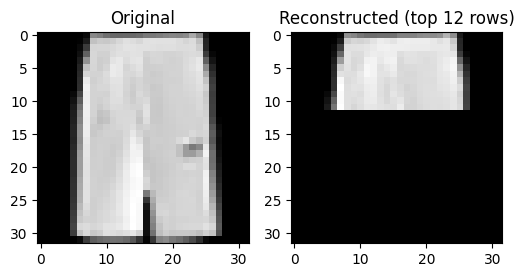

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from safetensors.torch import save_file, load_file
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random
import os

# ─── FashionNet Loader for Image Input ─────────────────────────────────────

def load_fashionnet(batch_size=8):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=True, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# ─── Shock Gate and Reconstruct ─────────────────────────────────────────────

def shock_and_reconstruct(shunt_model_path, input_dim=384, batch_size=1, magnitude=20.0):
    model = MinimalShunt(input_dim=input_dim)
    state_dict = load_file(shunt_model_path)
    model.load_state_dict(state_dict)
    model.eval()

    loader = load_fashionnet(batch_size=batch_size)
    for batch_idx, (images, labels) in enumerate(loader):
        original = images.clone()
        flat = images.view(images.size(0), -1).unsqueeze(1)  # [B, 1, 1024]
        if flat.shape[-1] < input_dim:
            pad = torch.zeros(flat.size(0), 1, input_dim - flat.size(-1))
            flat = torch.cat([flat, pad], dim=-1)
        elif flat.shape[-1] > input_dim:
            flat = flat[:, :, :input_dim]

        input_a = flat
        noise = torch.randn_like(flat) * magnitude
        input_b = flat + noise

        with torch.no_grad():
            outputs = model(input_a, input_b)

        recon_flat = (input_a + outputs["delta"]).squeeze(0)[0]  # [384]
        recon_img = torch.zeros(1024)
        recon_img[:recon_flat.numel()] = recon_flat
        recon_img = recon_img.view(32, 32)
        recon_img = torch.clamp(recon_img, -1, 1) * 0.5 + 0.5  # denormalize

        # Mask out unused region
        recon_masked = recon_img.clone()
        recon_masked[12:, :] = 0.0  # bottom 20 rows masked

        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        axes[0].imshow(original.squeeze().cpu().numpy(), cmap="gray")
        axes[0].set_title("Original")
        axes[1].imshow(recon_masked.cpu().numpy(), cmap="gray")
        axes[1].set_title("Reconstructed (top 12 rows)")
        plt.show()
        break



shock_and_reconstruct("/content/10k/minimal_shunt_final.safetensors", magnitude=1.0)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from safetensors.torch import save_file
import random
import os

label_texts = [
    "t-shirt", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"
]

# Build T5 or MiniLM representations for these
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
encoder = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

with torch.no_grad():
    tokenized = tokenizer(label_texts, padding=True, return_tensors="pt")
    class_embeddings = encoder(**tokenized).last_hidden_state.mean(1)  # shape [10, 384]




# ─── Pocket Block ──────────────────────────────────────────────────────────
class BottleneckResBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.conv = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=1)
        self.proj = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.conv(x.transpose(1, 2)).transpose(1, 2)
        return residual + self.proj(x)


class MinimalShunt(nn.Module):
    def __init__(
        self,
        input_dim=384,
        bneck=256,
        heads=8,
        tau_init=0.01,
        use_norm=True,
        use_do=True,
        do_p=0.1,
        proj_depth=2
    ):
        super().__init__()

        def build_projection(input_dim, output_dim):
            layers = []
            last_dim = input_dim
            if use_norm:
                layers.append(nn.LayerNorm(last_dim))
            for i in range(proj_depth):
                next_dim = bneck * (2 if i == 0 and proj_depth > 1 else 1)
                layers.append(nn.Linear(last_dim, next_dim))
                layers.append(nn.GELU())
                if use_do:
                    layers.append(nn.Dropout(do_p))
                last_dim = next_dim
            layers.append(nn.Linear(last_dim, output_dim))
            return nn.Sequential(*layers)

        self.proj_a = build_projection(input_dim, bneck)
        self.proj_b = build_projection(input_dim, bneck)

        self.cross_a2b = nn.MultiheadAttention(bneck, heads, batch_first=True, dropout=do_p)
        self.cross_b2a = nn.MultiheadAttention(bneck, heads, batch_first=True, dropout=do_p)

        self.pocket_a2b = BottleneckResBlock(bneck, dropout=do_p)
        self.pocket_b2a = BottleneckResBlock(bneck, dropout=do_p)

        self.delta_proj = build_projection(bneck, input_dim)
        self.gate_proj = nn.Sequential(
            nn.LayerNorm(bneck),
            nn.Linear(bneck, bneck),
            nn.GELU(),
            nn.Linear(bneck, 1),
            nn.Tanh(),
            nn.Sigmoid()
        )

        self.tau = nn.Parameter(torch.full((heads, 1, 1), tau_init))

        # Additional dynamic modules
        self.anchor_proj = build_projection(bneck, input_dim)
        self.cre_basis = nn.Parameter(torch.randn(6, input_dim))  # Collapse Residual Emission basis vectors
        self.attractor = nn.Parameter(torch.randn(1, 1, input_dim))  # Collapse Vector Potential attractor

    def forward(self, input_a: torch.Tensor, input_b: torch.Tensor):
        assert input_a.shape[-1] == input_b.shape[-1], "Input tensors must have the same feature dimension"

        a_b = self.proj_a(input_a)
        b_b = self.proj_b(input_b)

        a2b, attn_a2b = self.cross_a2b(a_b, b_b, b_b, need_weights=True, average_attn_weights=False)
        b2a, attn_b2a = self.cross_b2a(b_b, a_b, a_b, need_weights=True, average_attn_weights=False)

        a2b_pocketed = self.pocket_a2b(a2b)
        b2a_pocketed = self.pocket_b2a(b2a)
        core = (a2b_pocketed.mean(1, keepdim=True) + b2a_pocketed.mean(1, keepdim=True)) / 2


        gate = self.gate_proj(core)
        delta = self.delta_proj(core) * gate
        anchor = self.anchor_proj(core)

        # Collapse Residual Emission: project delta against CRE basis
        cre_energy = torch.stack([torch.sum(delta * b, dim=-1) for b in self.cre_basis], dim=-1)

        # Collapse Vector Potential Loss (alignment with attractor)
        attractor_norm = F.normalize(self.attractor, dim=-1)
        delta_norm = F.normalize(delta, dim=-1)
        cvp_alignment = torch.sum(delta_norm * attractor_norm, dim=-1, keepdim=True)

        return {
            "delta": delta,
            "anchor": anchor,
            "gate": gate,
            "attn_a2b": attn_a2b,
            "attn_b2a": attn_b2a,
            "tau": self.tau,
            "cre_energy": cre_energy,
            "cvp_alignment": cvp_alignment
        }

# ─── Test Harness: Inject Text or Noise into Shunt ─────────────────────────────

def train_shunt_on_fashion(shunt_model, class_embeddings, steps=10000, input_dim=384, tokens=6, lr=1e-4):
    optimizer = torch.optim.AdamW(shunt_model.parameters(), lr=lr)
    loader = load_fashionnet(batch_size=8)
    shunt_model.train()

    it = iter(loader)
    for step in range(steps):
        try:
            images, labels = next(it)
        except StopIteration:
            it = iter(loader)
            images, labels = next(it)

        flat = images.view(images.size(0), -1).unsqueeze(1)
        if flat.shape[-1] < input_dim:
            pad = torch.zeros(flat.size(0), 1, input_dim - flat.size(-1))
            flat = torch.cat([flat, pad], dim=-1)
        else:
            flat = flat[:, :, :input_dim]

        input_a = flat
        input_b = class_embeddings[labels].unsqueeze(1).expand(-1, flat.shape[1], -1)

        outputs = shunt_model(input_a, input_b)
        delta = outputs["delta"]
        loss = F.mse_loss(delta, input_b)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % 100 == 0:
            print(f"Step {step} | Loss: {loss.item():.5f} | Gate: {outputs['gate'].mean().item():.5f}")


train_shunt_on_fashion(MinimalShunt(), class_embeddings)

Step 0 | Loss: 0.11901 | Gate: 0.53447
Step 100 | Loss: 0.02770 | Gate: 0.72484
Step 200 | Loss: 0.01270 | Gate: 0.72834
Step 300 | Loss: 0.01058 | Gate: 0.72730
Step 400 | Loss: 0.00542 | Gate: 0.72712
Step 500 | Loss: 0.00525 | Gate: 0.72704
Step 600 | Loss: 0.00448 | Gate: 0.72662
Step 700 | Loss: 0.00409 | Gate: 0.72641
Step 800 | Loss: 0.00362 | Gate: 0.72708
Step 900 | Loss: 0.00369 | Gate: 0.72606
Step 1000 | Loss: 0.00256 | Gate: 0.72659
Step 1100 | Loss: 0.00313 | Gate: 0.72563
Step 1200 | Loss: 0.00216 | Gate: 0.72373
Step 1300 | Loss: 0.00340 | Gate: 0.72504
Step 1400 | Loss: 0.00263 | Gate: 0.72816
Step 1500 | Loss: 0.00303 | Gate: 0.72444
Step 1600 | Loss: 0.00207 | Gate: 0.72791
Step 1700 | Loss: 0.00227 | Gate: 0.72458


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialCausality(nn.Module):
    def __init__(self, shunt_count, latent_dim=3, control_dim=384):
        super().__init__()
        self.shunt_count = shunt_count
        self.latent_dim = latent_dim
        self.positions = nn.Parameter(torch.randn(shunt_count, latent_dim))  # [n, 3]

        # Projects (x, y, z) into scalar multiplier per shunt
        self.position_proj = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.GELU(),
            nn.Linear(latent_dim * 2, 1),
            nn.Sigmoid()
        )

        # Optional: project position into a feature bias vector (e.g., input-aware routing)
        self.context_proj = nn.Sequential(
            nn.Linear(latent_dim, control_dim),
            nn.Tanh()
        )

    def forward(self):
        weights = self.position_proj(self.positions).squeeze(-1)  # shape [n]
        context = self.context_proj(self.positions)  # shape [n, control_dim]
        return weights, context


# Pocket block for detail retention
class BottleneckResBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.conv = nn.Conv1d(dim, dim, kernel_size=3, padding=1)
        self.proj = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.conv(x.transpose(1, 2)).transpose(1, 2)
        return residual + self.proj(x)

# Fully equipped resonant shunt
class MinimalShunt(nn.Module):
    def __init__(self, input_dim=384, bneck=64, heads=8, tau_init=0.01, gate_scale=1.0, dropout=0.0):
        super().__init__()

        self.proj_a = nn.Linear(input_dim, bneck)
        self.proj_b = nn.Linear(input_dim, bneck)

        self.cross_a2b = nn.MultiheadAttention(bneck, heads, batch_first=True, dropout=dropout)
        self.cross_b2a = nn.MultiheadAttention(bneck, heads, batch_first=True, dropout=dropout)

        self.pocket_a2b = BottleneckResBlock(bneck, dropout)
        self.pocket_b2a = BottleneckResBlock(bneck, dropout)

        self.delta_proj = nn.Linear(bneck, input_dim)
        self.anchor_proj = nn.Linear(bneck, input_dim)

        self.gate_proj = nn.Sequential(
            nn.LayerNorm(bneck),
            nn.Linear(bneck, bneck),
            nn.GELU(),
            nn.Linear(bneck, 1),
            nn.Tanh(),
            nn.Sigmoid()
        )

        self.cre_basis = nn.Parameter(torch.randn(6, input_dim))
        self.attractor = nn.Parameter(torch.randn(1, 1, input_dim))
        self.tau = nn.Parameter(torch.full((heads, 1, 1), tau_init))
        self.gate_scale = gate_scale

    def forward(self, input_a, input_b):
        a_b = self.proj_a(input_a)
        b_b = self.proj_b(input_b)

        a2b, _ = self.cross_a2b(a_b, b_b, b_b)
        b2a, _ = self.cross_b2a(b_b, a_b, a_b)

        a2b = self.pocket_a2b(a2b)
        b2a = self.pocket_b2a(b2a)

        core = (a2b.mean(1, keepdim=True) + b2a.mean(1, keepdim=True)) / 2

        gate = self.gate_proj(core)
        delta = self.delta_proj(core) * gate * self.gate_scale
        anchor = self.anchor_proj(core)

        delta_norm = F.normalize(delta, dim=-1)
        attractor_norm = F.normalize(self.attractor, dim=-1)
        cre_energy = torch.stack([torch.sum(delta * b, dim=-1) for b in self.cre_basis], dim=-1)
        cvp_alignment = torch.sum(delta_norm * attractor_norm, dim=-1, keepdim=True)

        return {
            "delta": delta,
            "anchor": anchor,
            "gate": gate,
            "cre_energy": cre_energy,
            "cvp_alignment": cvp_alignment,
            "tau": self.tau,
        }


import torch
import torch.nn as nn
import torch.nn.functional as F

# ─── Learnable Spatial Modulator ─────────────────────────────────────────────
class SpatialCausality(nn.Module):
    def __init__(self, shunt_count, latent_dim=3, control_dim=384):
        super().__init__()
        self.positions = nn.Parameter(torch.randn(shunt_count, latent_dim))  # [n, 3]

        self.position_proj = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.GELU(),
            nn.Linear(latent_dim * 2, 1),
            nn.Sigmoid()
        )

        self.context_proj = nn.Sequential(
            nn.Linear(latent_dim, control_dim),
            nn.Tanh()
        )

    def forward(self):
        scalars = self.position_proj(self.positions).squeeze(-1)  # [n]
        vectors = self.context_proj(self.positions)               # [n, D]
        return scalars, vectors

# ─── Harmonically Aligned Collective ─────────────────────────────────────────
class HarmonicCollective(nn.Module):
    def __init__(self, shunt_cls, count=10, input_dim=384, bneck=256, heads=8, tau_init=0.01):
        super().__init__()
        self.shunts = nn.ModuleList([
            shunt_cls(input_dim=input_dim, bneck=bneck, heads=heads, tau_init=tau_init)
            for _ in range(count)
        ])
        self.spatial_causality = SpatialCausality(count, latent_dim=3, control_dim=input_dim)

    def forward(self, input_a, input_b):
        scalars, context_vectors = self.spatial_causality()  # [n], [n, D]
        outputs = []

        for i, shunt in enumerate(self.shunts):
            out = shunt(input_a, input_b)
            out["delta"] = out["delta"] * scalars[i]          # Apply spatial multiplier
            out["spatial_context"] = context_vectors[i]       # Optional: spatial influence field
            outputs.append(out)

        return outputs



In [ ]:
import torch
import numpy as np
import random
import os

def seed_all(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # CUDA-specific
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

label_texts = [
    "t-shirt", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "ankle boot"
]

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
encoder = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

with torch.no_grad():
    tokens = tokenizer(label_texts, padding=True, return_tensors="pt")
    class_embeds = encoder(**tokens).last_hidden_state.mean(1)  # shape [10, 384]


def train_harmonic_classifier(collective, per_class_loaders, steps=1000, input_dim=384, lr=1e-4):
    optimizer = torch.optim.AdamW(collective.parameters(), lr=lr)
    collective.train()

    for step in range(steps):
        class_idx = step % len(per_class_loaders)
        loader = per_class_loaders[class_idx]
        images = next(iter(loader))  # Get batch of one class

        flat = images.view(images.size(0), -1).unsqueeze(1)
        if flat.shape[-1] < input_dim:
            pad = torch.zeros(flat.size(0), 1, input_dim - flat.size(-1))
            flat = torch.cat([flat, pad], dim=-1)

        # Neutral conditioning — can also try a learned null vector
        input_b = torch.zeros_like(flat)

        outputs = collective(flat, input_b)

        active_output = outputs[class_idx]
        loss = F.mse_loss(active_output["delta"], flat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            resonance = active_output["delta"].norm().item()
            print(f"[Step {step}] Class {class_idx} | Loss: {loss.item():.5f} | Resonance: {resonance:.5f}")



seed_all()
collective = HarmonicCollective(MinimalShunt, count=10, input_dim=384)
train_harmonic_classifier(collective, class_embeds, steps=1000)


IndexError: Dimension specified as 0 but tensor has no dimensions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ─── Learnable Spatial Modulator ─────────────────────────────────────────────
class SpatialCausality(nn.Module):
    def __init__(self, shunt_count, latent_dim=3, control_dim=384):
        super().__init__()
        self.positions = nn.Parameter(torch.randn(shunt_count, latent_dim))  # [n, 3]

        self.position_proj = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.GELU(),
            nn.Linear(latent_dim * 2, 1),
            nn.Sigmoid()
        )

        self.context_proj = nn.Sequential(
            nn.Linear(latent_dim, control_dim),
            nn.Tanh()
        )

    def forward(self):
        scalars = self.position_proj(self.positions).squeeze(-1)  # [n]
        vectors = self.context_proj(self.positions)               # [n, D]
        return scalars, vectors

# ─── Pocket block for detail retention ──────────────────────────────────────
class BottleneckResBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.conv = nn.Conv1d(dim, dim, kernel_size=3, padding=1)
        self.proj = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.conv(x.transpose(1, 2)).transpose(1, 2)
        return residual + self.proj(x)

# ─── Fully equipped resonant shunt ──────────────────────────────────────────
class MinimalShunt(nn.Module):
    def __init__(self, input_dim=384, bneck=64, heads=8, tau_init=0.01, gate_scale=1.0, dropout=0.0):
        super().__init__()

        self.proj_a = nn.Linear(input_dim, bneck)
        self.proj_b = nn.Linear(input_dim, bneck)

        self.cross_a2b = nn.MultiheadAttention(bneck, heads, batch_first=True, dropout=dropout)
        self.cross_b2a = nn.MultiheadAttention(bneck, heads, batch_first=True, dropout=dropout)

        self.pocket_a2b = BottleneckResBlock(bneck, dropout)
        self.pocket_b2a = BottleneckResBlock(bneck, dropout)

        self.delta_proj = nn.Linear(bneck, input_dim)
        self.anchor_proj = nn.Linear(bneck, input_dim)

        self.gate_proj = nn.Sequential(
            nn.LayerNorm(bneck),
            nn.Linear(bneck, bneck),
            nn.GELU(),
            nn.Linear(bneck, 1),
            nn.Tanh(),
            nn.Sigmoid()
        )

        self.cre_basis = nn.Parameter(torch.randn(6, input_dim))
        self.attractor = nn.Parameter(torch.randn(1, 1, input_dim))
        self.tau = nn.Parameter(torch.full((heads, 1, 1), tau_init))
        self.gate_scale = gate_scale

    def forward(self, input_a, input_b):
        a_b = self.proj_a(input_a)
        b_b = self.proj_b(input_b)

        a2b, _ = self.cross_a2b(a_b, b_b, b_b)
        b2a, _ = self.cross_b2a(b_b, a_b, a_b)

        a2b = self.pocket_a2b(a2b)
        b2a = self.pocket_b2a(b2a)

        core = (a2b.mean(1, keepdim=True) + b2a.mean(1, keepdim=True)) / 2

        gate = self.gate_proj(core)
        delta = self.delta_proj(core) * gate * self.gate_scale
        anchor = self.anchor_proj(core)

        delta_norm = F.normalize(delta, dim=-1)
        attractor_norm = F.normalize(self.attractor, dim=-1)
        cre_energy = torch.stack([torch.sum(delta * b, dim=-1) for b in self.cre_basis], dim=-1)
        cvp_alignment = torch.sum(delta_norm * attractor_norm, dim=-1, keepdim=True)

        return {
            "delta": delta,
            "anchor": anchor,
            "gate": gate,
            "cre_energy": cre_energy,
            "cvp_alignment": cvp_alignment,
            "tau": self.tau,
        }

# ─── Harmonically Aligned Collective ────────────────────────────────────────
class HarmonicCollective(nn.Module):
    def __init__(self, shunt_cls, count=10, input_dim=384, bneck=64, heads=8, tau_init=0.01):
        super().__init__()
        self.shunts = nn.ModuleList([
            shunt_cls(input_dim=input_dim, bneck=bneck, heads=heads, tau_init=tau_init)
            for _ in range(count)
        ])
        self.spatial_causality = SpatialCausality(count, latent_dim=3, control_dim=input_dim)

    def forward(self, input_a, input_b):
        scalars, context_vectors = self.spatial_causality()  # [n], [n, D]
        outputs = []

        for i, shunt in enumerate(self.shunts):
            out = shunt(input_a, input_b)
            out["delta"] = out["delta"] * scalars[i]
            out["spatial_context"] = context_vectors[i]
            outputs.append(out)

        return outputs


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Define the MinimalShunt architecture
class MinimalShunt(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Encoder for input_a (image features)
        self.encoder_a = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Encoder for input_b (target/neutral)
        self.encoder_b = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Cross-attention for harmonic alignment
        self.cross_attn = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)

        # Output heads
        self.delta_head = nn.Linear(hidden_dim, input_dim)
        self.gate_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_a, input_b):
        # Encode both inputs
        feat_a = self.encoder_a(input_a)
        feat_b = self.encoder_b(input_b)

        # Cross-attention: how much should a influence b?
        attn_out, _ = self.cross_attn(feat_a, feat_b, feat_b)

        # Generate delta and gate
        delta = self.delta_head(attn_out)
        gate = self.gate_head(attn_out)

        return {
            "delta": delta,
            "gate": gate,
            "features": attn_out
        }

# Define the HarmonicCollective
class HarmonicCollective(nn.Module):
    def __init__(self, shunt_class, num_shunts=10, input_dim=384):
        super().__init__()
        self.num_shunts = num_shunts
        self.shunts = nn.ModuleList([
            shunt_class(input_dim=input_dim) for _ in range(num_shunts)
        ])

        # Harmonic resonance layer - determines which shunt responds
        self.resonance = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_shunts),
            nn.Softmax(dim=-1)
        )

    def forward(self, input_a, input_b):
        # Calculate resonance scores for input_a
        flat_a = input_a.view(input_a.size(0), -1)
        resonance_scores = self.resonance(flat_a).unsqueeze(1)  # [B, 1, num_shunts]

        # Get outputs from all shunts
        all_outputs = []
        for i, shunt in enumerate(self.shunts):
            output = shunt(input_a, input_b)
            # Weight by resonance score
            output["resonance_weight"] = resonance_scores[:, :, i:i+1]
            all_outputs.append(output)

        return all_outputs

# Dataset class with optimized loading
class PerClassDataset(torch.utils.data.Dataset):
    def __init__(self, target_class: int, num_samples: int = 8, preloaded_data=None):
        self.target_class = target_class
        self.num_samples = num_samples

        if preloaded_data is not None:
            # Use preloaded data
            self.samples = preloaded_data[target_class]
        else:
            # Load data (fallback, shouldn't be used with build_per_shunt_loaders)
            transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=True, download=True, transform=transform)
            self.samples = [img for img, label in dataset if label == target_class]

        # Select random samples
        if len(self.samples) >= num_samples:
            self.selected = random.sample(self.samples, num_samples)
        else:
            # If not enough samples, repeat some
            self.selected = random.choices(self.samples, k=num_samples)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.selected[idx]

# Dataset class with full dataset support
class PerClassDataset(torch.utils.data.Dataset):
    def __init__(self, target_class: int, samples, use_all=True):
        self.target_class = target_class
        self.samples = samples
        self.use_all = use_all

        if not use_all and len(samples) > 8:
            # For testing: use subset
            self.selected = random.sample(samples, 8)
        else:
            # Use all samples
            self.selected = samples

    def __len__(self):
        return len(self.selected)

    def __getitem__(self, idx):
        return self.selected[idx]

def build_per_shunt_loaders(num_shunts=10, batch_size=32, use_full_dataset=True):
    """Build dataloaders using the entire dataset"""
    from tqdm import tqdm

    print("Loading and organizing FashionMNIST dataset...")

    # Load the full dataset once
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=True, download=True, transform=transform)

    # Organize by class with progress bar
    class_samples = {i: [] for i in range(num_shunts)}

    print("Organizing samples by class...")
    for img, label in tqdm(dataset, desc="Processing FashionMNIST", total=len(dataset)):
        if label < num_shunts:
            class_samples[label].append(img)

    # Create dataloaders
    loaders = []
    for class_idx in range(num_shunts):
        dataset = PerClassDataset(class_idx, class_samples[class_idx], use_all=use_full_dataset)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        loaders.append(loader)

    print(f"\nCreated {len(loaders)} class-specific dataloaders")
    total_samples = 0
    for i in range(num_shunts):
        num_samples = len(class_samples[i])
        total_samples += num_samples
        print(f"  Class {i}: {num_samples:,} samples")
    print(f"  Total: {total_samples:,} samples")

    return loaders

def train_harmonic_classifier(model, loaders, input_dim=384, epochs=10, lr=1e-4, device='cuda'):
    """Train on full dataset with epoch-based training"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(loaders) * 100)
    model.train().to(device)

    # Tracking metrics
    epoch_losses = []
    gate_accuracy = []
    resonance_accuracy = []

    # Create iterators for each loader
    loader_iters = [iter(loader) for loader in loaders]

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1}/{epochs} ---")
        epoch_loss = 0
        correct_gates = 0
        correct_resonance = 0
        total_samples = 0

        # Progress bar for the epoch
        steps_per_epoch = min(len(loader) for loader in loaders) * len(loaders)
        pbar = tqdm(total=steps_per_epoch, desc=f"Epoch {epoch + 1}")

        # Train on each class in rotation
        for step in range(steps_per_epoch):
            class_idx = step % len(loaders)

            # Get next batch, reset iterator if needed
            try:
                images = next(loader_iters[class_idx])
            except StopIteration:
                loader_iters[class_idx] = iter(loaders[class_idx])
                images = next(loader_iters[class_idx])

            images = images.to(device)
            batch_size = images.size(0)
            total_samples += batch_size

            # Prepare inputs
            flat = images.view(batch_size, -1).unsqueeze(1)  # [B, 1, 1024]
            if flat.shape[-1] < input_dim:
                pad = torch.zeros(batch_size, 1, input_dim - flat.shape[-1], device=device)
                flat = torch.cat([flat, pad], dim=-1)
            else:
                flat = flat[:, :, :input_dim]

            input_a = flat
            input_b = torch.zeros_like(flat)  # neutral target

            outputs = model(input_a, input_b)

            # Loss calculation with harmonic specialization
            total_loss = 0

            # Track which shunt has highest activation
            max_gates = []
            max_resonances = []

            for i, output in enumerate(outputs):
                if i == class_idx:
                    # Target shunt should reconstruct well
                    reconstruction_loss = F.mse_loss(output["delta"], flat)
                    gate_loss = F.mse_loss(output["gate"], torch.ones_like(output["gate"]))
                    resonance_loss = F.mse_loss(output["resonance_weight"], torch.ones_like(output["resonance_weight"]))

                    shunt_loss = reconstruction_loss + 0.1 * gate_loss + 0.1 * resonance_loss
                else:
                    # Other shunts should stay quiet
                    gate_loss = F.mse_loss(output["gate"], torch.zeros_like(output["gate"]))
                    resonance_loss = F.mse_loss(output["resonance_weight"], torch.zeros_like(output["resonance_weight"]))

                    shunt_loss = 0.5 * gate_loss + 0.5 * resonance_loss

                total_loss += shunt_loss
                max_gates.append(output["gate"].mean())
                max_resonances.append(output["resonance_weight"].mean())

            # Calculate accuracy
            max_gates = torch.stack(max_gates)
            max_resonances = torch.stack(max_resonances)
            pred_gate = torch.argmax(max_gates)
            pred_resonance = torch.argmax(max_resonances)

            if pred_gate == class_idx:
                correct_gates += batch_size
            if pred_resonance == class_idx:
                correct_resonance += batch_size

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += total_loss.item()

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({
                'loss': f'{total_loss.item():.4f}',
                'gate_acc': f'{correct_gates/total_samples:.2%}',
                'res_acc': f'{correct_resonance/total_samples:.2%}'
            })

        pbar.close()

        # Epoch statistics
        avg_epoch_loss = epoch_loss / steps_per_epoch
        gate_acc = correct_gates / total_samples
        res_acc = correct_resonance / total_samples

        epoch_losses.append(avg_epoch_loss)
        gate_accuracy.append(gate_acc)
        resonance_accuracy.append(res_acc)

        print(f"Epoch {epoch + 1} Summary:")
        print(f"  Average Loss: {avg_epoch_loss:.4f}")
        print(f"  Gate Accuracy: {gate_acc:.2%}")
        print(f"  Resonance Accuracy: {res_acc:.2%}")
        print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    return epoch_losses, gate_accuracy, resonance_accuracy

def visualize_full_training(epoch_losses, gate_accuracy, resonance_accuracy):
    """Visualize training metrics for full dataset training"""
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Loss curve
    axes[0].plot(epoch_losses, 'b-', linewidth=2)
    axes[0].set_title("Training Loss per Epoch", fontsize=14)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Average Loss")
    axes[0].grid(True, alpha=0.3)

    # Accuracy curves
    epochs = range(1, len(gate_accuracy) + 1)
    axes[1].plot(epochs, gate_accuracy, 'g-', linewidth=2, label='Gate Accuracy')
    axes[1].plot(epochs, resonance_accuracy, 'r-', linewidth=2, label='Resonance Accuracy')
    axes[1].set_title("Classification Accuracy per Epoch", fontsize=14)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_ylim(0, 1.05)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # Add percentage labels
    for i, (g, r) in enumerate(zip(gate_accuracy, resonance_accuracy)):
        if i == len(gate_accuracy) - 1:  # Last epoch
            axes[1].text(i + 1, g + 0.02, f'{g:.1%}', ha='center', va='bottom', color='green')
            axes[1].text(i + 1, r - 0.02, f'{r:.1%}', ha='center', va='top', color='red')

    plt.tight_layout()
    plt.show()

def test_specialization(model, num_classes=10, device='cuda'):
    """Test if shunts have specialized to specific classes"""
    model.eval()

    # Create test samples from each class
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=False, download=True, transform=transform)

    # Get one sample from each class
    class_samples = {}
    for img, label in dataset:
        if label not in class_samples:
            class_samples[label] = img
        if len(class_samples) == num_classes:
            break

    # Test resonance patterns
    resonance_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for true_class, img in class_samples.items():
            img = img.unsqueeze(0).to(device)
            flat = img.view(1, -1).unsqueeze(1)

            if flat.shape[-1] < 384:
                pad = torch.zeros(1, 1, 384 - flat.shape[-1], device=device)
                flat = torch.cat([flat, pad], dim=-1)
            else:
                flat = flat[:, :, :384]

            input_a = flat
            input_b = torch.zeros_like(flat)

            outputs = model(input_a, input_b)

            for shunt_idx, output in enumerate(outputs):
                resonance_matrix[true_class, shunt_idx] = output["resonance_weight"].mean().item()

    # Visualize specialization
    plt.figure(figsize=(10, 8))
    plt.imshow(resonance_matrix.numpy(), cmap='hot', interpolation='nearest')
    plt.colorbar(label='Resonance Score')
    plt.xlabel('Shunt Index')
    plt.ylabel('True Class')
    plt.title('Shunt Specialization Matrix\n(Diagonal = Perfect Specialization)')

    # Add grid
    for i in range(num_classes):
        plt.axhline(i - 0.5, color='gray', linewidth=0.5)
        plt.axvline(i - 0.5, color='gray', linewidth=0.5)

    plt.tight_layout()
    plt.show()

    return resonance_matrix

# Main execution
if __name__ == "__main__":
    # Setup
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Build data loaders
    print("Building per-class data loaders...")
    loaders = build_per_shunt_loaders(num_shunts=10, batch_size=8)

    # Create model
    print("Creating Harmonic Collective model...")
    collective = HarmonicCollective(MinimalShunt, num_shunts=10, input_dim=384)

    # Train
    print("Starting harmonic training...")
    losses, gate_values, resonance_values = train_harmonic_classifier(
        collective, loaders, input_dim=384, lr=1e-4, device=device
    )

    # Visualize training
    print("Visualizing training metrics...")
    visualize_training(losses, gate_values, resonance_values)

    # Test specialization
    print("Testing shunt specialization...")
    resonance_matrix = test_specialization(collective, device=device)

    # Print specialization score
    diagonal_score = torch.diag(resonance_matrix).mean().item()
    off_diagonal_score = (resonance_matrix.sum() - torch.diag(resonance_matrix).sum()).item() / (100 - 10)
    print(f"\nSpecialization Score:")
    print(f"  Diagonal (correct): {diagonal_score:.3f}")
    print(f"  Off-diagonal (incorrect): {off_diagonal_score:.3f}")
    print(f"  Ratio: {diagonal_score / (off_diagonal_score + 1e-6):.2f}x")

Using device: cpu
Building per-class data loaders with validation split...
Loading and organizing FashionMNIST dataset...
Organizing samples by class...


Processing FashionMNIST: 100%|██████████| 60000/60000 [00:12<00:00, 4964.29it/s]


Created 10 class-specific dataloaders
  Class 0: 5,400 train, 600 validation
  Class 1: 5,400 train, 600 validation
  Class 2: 5,400 train, 600 validation
  Class 3: 5,400 train, 600 validation
  Class 4: 5,400 train, 600 validation
  Class 5: 5,400 train, 600 validation
  Class 6: 5,400 train, 600 validation
  Class 7: 5,400 train, 600 validation
  Class 8: 5,400 train, 600 validation
  Class 9: 5,400 train, 600 validation
  Total: 54,000 train, 6,000 validation
Creating Harmonic Collective model...

Starting harmonic training with validation monitoring...



--- Epoch 1/20 ---


Epoch 1: 100%|██████████| 1690/1690 [01:37<00:00, 17.39it/s, loss=0.3311, gate_acc=7.63%, res_acc=85.48%]

Validating...



Epoch 1 Summary:
  Training   - Loss: 0.4506, Gate Acc: 7.63%, Resonance Acc: 85.48%
  Validation - Loss: 0.3230, Gate Acc: 10.00%, Resonance Acc: 98.93%
  Learning Rate: 0.000098

Checkpoint saved: harmonic_collective_epoch1_gate10.0_res98.9_20250607_213633.safetensors
New best model saved with resonance accuracy: 9893.33%

--- Epoch 2/20 ---


Epoch 2: 100%|██████████| 1690/1690 [01:33<00:00, 18.14it/s, loss=0.2564, gate_acc=6.93%, res_acc=99.05%]

Validating...



Epoch 2 Summary:
  Training   - Loss: 0.3244, Gate Acc: 6.93%, Resonance Acc: 99.05%
  Validation - Loss: 0.3180, Gate Acc: 10.00%, Resonance Acc: 99.47%
  Learning Rate: 0.000093

Checkpoint saved: harmonic_collective_epoch2_gate10.0_res99.5_20250607_213809.safetensors
New best model saved with resonance accuracy: 9946.67%

--- Epoch 3/20 ---


Epoch 3: 100%|██████████| 1690/1690 [01:32<00:00, 18.25it/s, loss=0.2461, gate_acc=7.39%, res_acc=99.82%]

Validating...



Epoch 3 Summary:
  Training   - Loss: 0.3203, Gate Acc: 7.39%, Resonance Acc: 99.82%
  Validation - Loss: 0.3145, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000085

Checkpoint saved: harmonic_collective_epoch3_gate10.0_res100.0_20250607_213946.safetensors
New best model saved with resonance accuracy: 10000.00%

--- Epoch 4/20 ---


Epoch 4: 100%|██████████| 1690/1690 [01:39<00:00, 17.02it/s, loss=0.2639, gate_acc=7.27%, res_acc=99.94%]

Validating...



Epoch 4 Summary:
  Training   - Loss: 0.3177, Gate Acc: 7.27%, Resonance Acc: 99.94%
  Validation - Loss: 0.3126, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000074

--- Epoch 5/20 ---


Epoch 5: 100%|██████████| 1690/1690 [01:36<00:00, 17.46it/s, loss=0.3016, gate_acc=8.18%, res_acc=99.88%]

Validating...



Epoch 5 Summary:
  Training   - Loss: 0.3159, Gate Acc: 8.18%, Resonance Acc: 99.88%
  Validation - Loss: 0.3112, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000062

--- Epoch 6/20 ---


Epoch 6: 100%|██████████| 1690/1690 [01:38<00:00, 17.22it/s, loss=0.2618, gate_acc=8.46%, res_acc=100.00%]

Validating...



Epoch 6 Summary:
  Training   - Loss: 0.3145, Gate Acc: 8.46%, Resonance Acc: 100.00%
  Validation - Loss: 0.3101, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000049

--- Epoch 7/20 ---


Epoch 7: 100%|██████████| 1690/1690 [01:39<00:00, 16.96it/s, loss=0.2918, gate_acc=7.57%, res_acc=99.88%]

Validating...



Epoch 7 Summary:
  Training   - Loss: 0.3134, Gate Acc: 7.57%, Resonance Acc: 99.88%
  Validation - Loss: 0.3096, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000036

--- Epoch 8/20 ---


Epoch 8: 100%|██████████| 1690/1690 [01:38<00:00, 17.08it/s, loss=0.2383, gate_acc=7.53%, res_acc=99.94%]

Validating...



Epoch 8 Summary:
  Training   - Loss: 0.3126, Gate Acc: 7.53%, Resonance Acc: 99.94%
  Validation - Loss: 0.3090, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000024

--- Epoch 9/20 ---


Epoch 9: 100%|██████████| 1690/1690 [01:39<00:00, 16.96it/s, loss=0.3146, gate_acc=8.22%, res_acc=99.88%]

Validating...



Epoch 9 Summary:
  Training   - Loss: 0.3120, Gate Acc: 8.22%, Resonance Acc: 99.88%
  Validation - Loss: 0.3087, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000013

--- Epoch 10/20 ---


Epoch 10: 100%|██████████| 1690/1690 [01:39<00:00, 17.04it/s, loss=0.2996, gate_acc=8.52%, res_acc=100.00%]

Validating...



Epoch 10 Summary:
  Training   - Loss: 0.3116, Gate Acc: 8.52%, Resonance Acc: 100.00%
  Validation - Loss: 0.3085, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000006

--- Epoch 11/20 ---


Epoch 11: 100%|██████████| 1690/1690 [01:37<00:00, 17.42it/s, loss=0.2624, gate_acc=9.59%, res_acc=99.94%]

Validating...



Epoch 11 Summary:
  Training   - Loss: 0.3113, Gate Acc: 9.59%, Resonance Acc: 99.94%
  Validation - Loss: 0.3084, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000001

--- Epoch 12/20 ---


Epoch 12: 100%|██████████| 1690/1690 [01:38<00:00, 17.18it/s, loss=0.3054, gate_acc=9.94%, res_acc=99.94%]

Validating...



Epoch 12 Summary:
  Training   - Loss: 0.3112, Gate Acc: 9.94%, Resonance Acc: 99.94%
  Validation - Loss: 0.3084, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000000

--- Epoch 13/20 ---


Epoch 13: 100%|██████████| 1690/1690 [01:38<00:00, 17.24it/s, loss=0.3159, gate_acc=9.47%, res_acc=99.94%]

Validating...



Epoch 13 Summary:
  Training   - Loss: 0.3112, Gate Acc: 9.47%, Resonance Acc: 99.94%
  Validation - Loss: 0.3084, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000002

--- Epoch 14/20 ---


Epoch 14: 100%|██████████| 1690/1690 [01:37<00:00, 17.26it/s, loss=0.2824, gate_acc=8.81%, res_acc=99.88%]

Validating...



Epoch 14 Summary:
  Training   - Loss: 0.3113, Gate Acc: 8.81%, Resonance Acc: 99.88%
  Validation - Loss: 0.3084, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000008

--- Epoch 15/20 ---


Epoch 15: 100%|██████████| 1690/1690 [01:38<00:00, 17.22it/s, loss=0.3007, gate_acc=8.46%, res_acc=100.00%]

Validating...



Epoch 15 Summary:
  Training   - Loss: 0.3114, Gate Acc: 8.46%, Resonance Acc: 100.00%
  Validation - Loss: 0.3083, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000017

--- Epoch 16/20 ---


Epoch 16: 100%|██████████| 1690/1690 [01:39<00:00, 16.94it/s, loss=0.2931, gate_acc=7.87%, res_acc=100.00%]

Validating...



Epoch 16 Summary:
  Training   - Loss: 0.3114, Gate Acc: 7.87%, Resonance Acc: 100.00%
  Validation - Loss: 0.3082, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000028

--- Epoch 17/20 ---


Epoch 17: 100%|██████████| 1690/1690 [01:44<00:00, 16.22it/s, loss=0.2514, gate_acc=7.53%, res_acc=99.94%]

Validating...



Epoch 17 Summary:
  Training   - Loss: 0.3114, Gate Acc: 7.53%, Resonance Acc: 99.94%
  Validation - Loss: 0.3078, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000040

--- Epoch 18/20 ---


Epoch 18: 100%|██████████| 1690/1690 [01:41<00:00, 16.60it/s, loss=0.2552, gate_acc=7.81%, res_acc=99.94%]

Validating...



Epoch 18 Summary:
  Training   - Loss: 0.3113, Gate Acc: 7.81%, Resonance Acc: 99.94%
  Validation - Loss: 0.3078, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000053

--- Epoch 19/20 ---


Epoch 19: 100%|██████████| 1690/1690 [01:39<00:00, 16.95it/s, loss=0.2796, gate_acc=7.99%, res_acc=99.94%]

Validating...



Epoch 19 Summary:
  Training   - Loss: 0.3111, Gate Acc: 7.99%, Resonance Acc: 99.94%
  Validation - Loss: 0.3077, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000066

--- Epoch 20/20 ---


Epoch 20: 100%|██████████| 1690/1690 [01:39<00:00, 16.97it/s, loss=0.2820, gate_acc=7.69%, res_acc=100.00%]

Validating...



Epoch 20 Summary:
  Training   - Loss: 0.3107, Gate Acc: 7.69%, Resonance Acc: 100.00%
  Validation - Loss: 0.3071, Gate Acc: 10.00%, Resonance Acc: 100.00%
  Learning Rate: 0.000078

Training complete! Best validation resonance accuracy: 100.00%

Visualizing training metrics...


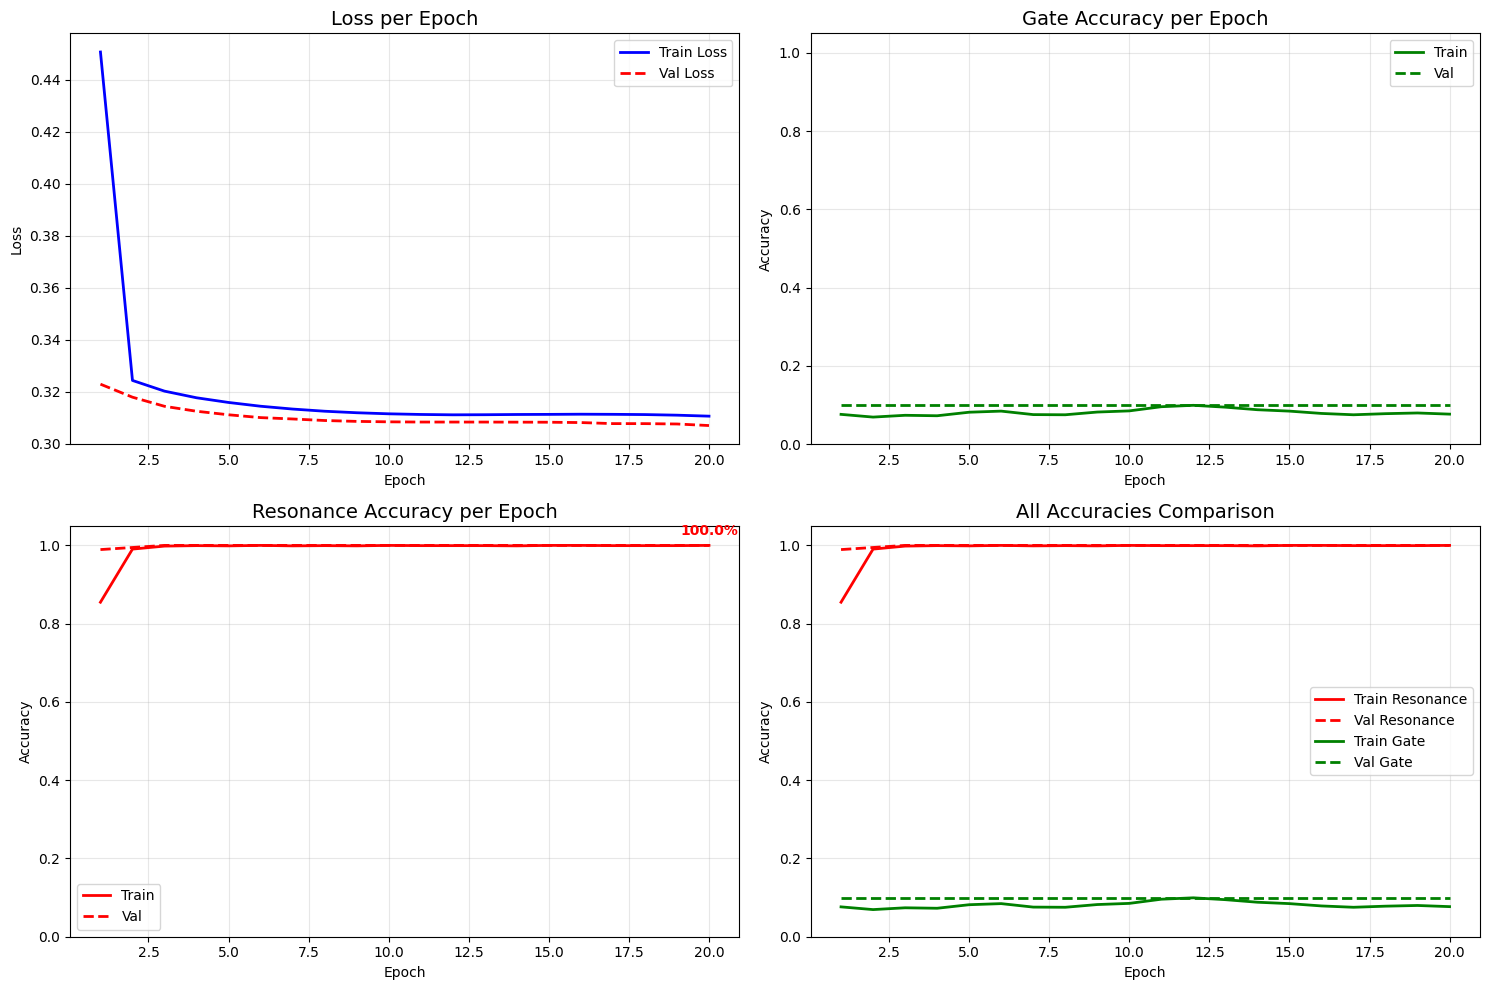


Testing shunt specialization...


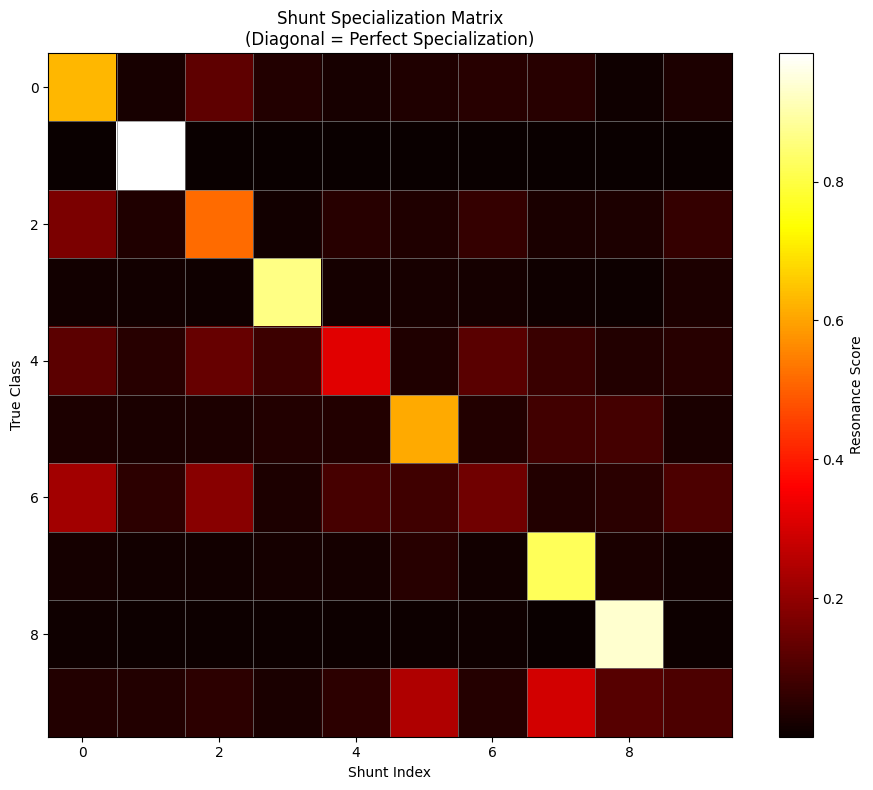


Specialization Score:
  Diagonal (correct): 0.593
  Off-diagonal (incorrect): 0.045
  Ratio: 13.13x

Training complete. Evaluating on held-out test set...

Evaluating on test set...


Testing: 100%|██████████| 79/79 [00:02<00:00, 39.35it/s]



Test Set Results:
  Gate Accuracy: 10.00%
  Resonance Accuracy: 73.76%

Per-Class Accuracy:
  T-shirt/top    : 57.00% (570/1000)
  Trouser        : 89.00% (890/1000)
  Pullover       : 54.70% (547/1000)
  Dress          : 80.20% (802/1000)
  Coat           : 70.10% (701/1000)
  Sandal         : 81.30% (813/1000)
  Shirt          : 42.60% (426/1000)
  Sneaker        : 76.90% (769/1000)
  Bag            : 93.30% (933/1000)
  Ankle boot     : 92.50% (925/1000)

Checkpoint saved: harmonic_collective_epoch20_gate10.0_res100.0_20250607_220900.safetensors
New best model saved with resonance accuracy: 10000.00%
Final model saved with test accuracy: checkpoints/harmonic_collective_epoch20_gate10.0_res100.0_20250607_220900_test73.8.safetensors

FINAL RESULTS SUMMARY
Best Validation Resonance Accuracy: 100.00%
Final Test Set Accuracy: 73.76%
Model saved to: checkpoints/harmonic_collective_epoch20_gate10.0_res100.0_20250607_220900_test73.8.safetensors


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from safetensors.torch import save_file, load_file
import os
from datetime import datetime

# Define the MinimalShunt architecture
class MinimalShunt(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Encoder for input_a (image features)
        self.encoder_a = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Encoder for input_b (target/neutral)
        self.encoder_b = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Cross-attention for harmonic alignment
        self.cross_attn = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)

        # Output heads
        self.delta_head = nn.Linear(hidden_dim, input_dim)
        self.gate_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_a, input_b):
        # Encode both inputs
        feat_a = self.encoder_a(input_a)
        feat_b = self.encoder_b(input_b)

        # Cross-attention: how much should a influence b?
        attn_out, _ = self.cross_attn(feat_a, feat_b, feat_b)

        # Generate delta and gate
        delta = self.delta_head(attn_out)
        gate = self.gate_head(attn_out)

        return {
            "delta": delta,
            "gate": gate,
            "features": attn_out
        }

# Define the HarmonicCollective
class HarmonicCollective(nn.Module):
    def __init__(self, shunt_class, num_shunts=10, input_dim=384):
        super().__init__()
        self.num_shunts = num_shunts
        self.shunts = nn.ModuleList([
            shunt_class(input_dim=input_dim) for _ in range(num_shunts)
        ])

        # Harmonic resonance layer - determines which shunt responds
        self.resonance = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_shunts),
            nn.Softmax(dim=-1)
        )

    def forward(self, input_a, input_b):
        # Calculate resonance scores for input_a
        flat_a = input_a.view(input_a.size(0), -1)
        resonance_scores = self.resonance(flat_a).unsqueeze(1)  # [B, 1, num_shunts]

        # Get outputs from all shunts
        all_outputs = []
        for i, shunt in enumerate(self.shunts):
            output = shunt(input_a, input_b)
            # Weight by resonance score
            output["resonance_weight"] = resonance_scores[:, :, i:i+1]
            all_outputs.append(output)

        return all_outputs

# Dataset class with full dataset support
class PerClassDataset(torch.utils.data.Dataset):
    def __init__(self, target_class: int, samples, use_all=True):
        self.target_class = target_class
        self.samples = samples
        self.use_all = use_all

        if not use_all and len(samples) > 8:
            # For testing: use subset
            self.selected = random.sample(samples, 8)
        else:
            # Use all samples
            self.selected = samples

    def __len__(self):
        return len(self.selected)

    def __getitem__(self, idx):
        return self.selected[idx]

def build_per_shunt_loaders(num_shunts=10, batch_size=32, use_full_dataset=True, val_split=0.1):
    """Build dataloaders with train/validation split"""
    from tqdm import tqdm

    print("Loading and organizing FashionMNIST dataset...")

    # Load the full dataset once
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=True, download=True, transform=transform)

    # Organize by class with progress bar
    class_samples = {i: [] for i in range(num_shunts)}

    print("Organizing samples by class...")
    for img, label in tqdm(dataset, desc="Processing FashionMNIST", total=len(dataset)):
        if label < num_shunts:
            class_samples[label].append(img)

    # Split into train and validation
    train_samples = {i: [] for i in range(num_shunts)}
    val_samples = {i: [] for i in range(num_shunts)}

    for class_idx in range(num_shunts):
        samples = class_samples[class_idx]
        random.shuffle(samples)  # Shuffle before splitting

        val_size = int(len(samples) * val_split)
        val_samples[class_idx] = samples[:val_size]
        train_samples[class_idx] = samples[val_size:]

    # Create dataloaders
    train_loaders = []
    val_loaders = []

    for class_idx in range(num_shunts):
        # Training loader
        train_dataset = PerClassDataset(class_idx, train_samples[class_idx], use_all=use_full_dataset)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        train_loaders.append(train_loader)

        # Validation loader
        val_dataset = PerClassDataset(class_idx, val_samples[class_idx], use_all=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        val_loaders.append(val_loader)

    print(f"\nCreated {len(train_loaders)} class-specific dataloaders")
    total_train = 0
    total_val = 0
    for i in range(num_shunts):
        num_train = len(train_samples[i])
        num_val = len(val_samples[i])
        total_train += num_train
        total_val += num_val
        print(f"  Class {i}: {num_train:,} train, {num_val:,} validation")
    print(f"  Total: {total_train:,} train, {total_val:,} validation")

    return train_loaders, val_loaders

def save_checkpoint(model, epoch, gate_acc, res_acc, save_dir="checkpoints"):
    """Save model checkpoint with safetensors"""
    os.makedirs(save_dir, exist_ok=True)

    # Create filename with metrics
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"harmonic_collective_epoch{epoch}_gate{gate_acc:.1f}_res{res_acc:.1f}_{timestamp}.safetensors"
    filepath = os.path.join(save_dir, filename)

    # Get state dict
    state_dict = model.state_dict()

    # Add metadata
    metadata = {
        "epoch": str(epoch),
        "gate_accuracy": f"{gate_acc:.4f}",
        "resonance_accuracy": f"{res_acc:.4f}",
        "num_shunts": str(model.num_shunts),
        "timestamp": timestamp,
        "model_type": "HarmonicCollective",
        "dataset": "FashionMNIST"
    }

    # Save with safetensors
    save_file(state_dict, filepath, metadata=metadata)
    print(f"\nCheckpoint saved: {filename}")

    # Also save the best model
    best_path = os.path.join(save_dir, "best_harmonic_collective.safetensors")
    if not os.path.exists(best_path) or res_acc > float(metadata.get("best_resonance_accuracy", "0")):
        metadata["best_resonance_accuracy"] = f"{res_acc:.4f}"
        save_file(state_dict, best_path, metadata=metadata)
        print(f"New best model saved with resonance accuracy: {res_acc:.2%}")

    return filepath

def load_checkpoint(filepath, model_class=HarmonicCollective, shunt_class=MinimalShunt, device='cpu'):
    """Load model from safetensors checkpoint"""
    # Load state dict and metadata
    state_dict = load_file(filepath)

    # Extract metadata if available
    # Note: safetensors metadata needs to be extracted differently
    # For now, parse from filename
    filename = os.path.basename(filepath)
    parts = filename.split('_')

    # Create model
    model = model_class(shunt_class, num_shunts=10, input_dim=384)
    model.load_state_dict(state_dict)
    model.to(device)

    print(f"Model loaded from: {filename}")
    return model

def validate_model(model, val_loaders, device='cuda'):
    """Validate model on validation set"""
    model.eval()

    correct_gates = 0
    correct_resonance = 0
    total = 0
    val_loss = 0
    num_batches = 0

    with torch.no_grad():
        for class_idx, loader in enumerate(val_loaders):
            for images in loader:
                images = images.to(device)
                batch_size = images.size(0)

                # Prepare inputs
                flat = images.view(batch_size, -1).unsqueeze(1)
                if flat.shape[-1] < 384:
                    pad = torch.zeros(batch_size, 1, 384 - flat.shape[-1], device=device)
                    flat = torch.cat([flat, pad], dim=-1)
                else:
                    flat = flat[:, :, :384]

                input_a = flat
                input_b = torch.zeros_like(flat)

                outputs = model(input_a, input_b)

                # Calculate validation loss
                batch_loss = 0
                max_gates = []
                max_resonances = []

                for i, output in enumerate(outputs):
                    if i == class_idx:
                        reconstruction_loss = F.mse_loss(output["delta"], flat)
                        gate_loss = F.mse_loss(output["gate"], torch.ones_like(output["gate"]))
                        resonance_loss = F.mse_loss(output["resonance_weight"], torch.ones_like(output["resonance_weight"]))
                        shunt_loss = reconstruction_loss + 0.1 * gate_loss + 0.1 * resonance_loss
                    else:
                        gate_loss = F.mse_loss(output["gate"], torch.zeros_like(output["gate"]))
                        resonance_loss = F.mse_loss(output["resonance_weight"], torch.zeros_like(output["resonance_weight"]))
                        shunt_loss = 0.5 * gate_loss + 0.5 * resonance_loss

                    batch_loss += shunt_loss
                    max_gates.append(output["gate"].mean())
                    max_resonances.append(output["resonance_weight"].mean())

                val_loss += batch_loss.item()
                num_batches += 1

                # Get predictions
                max_gates = torch.stack(max_gates)
                max_resonances = torch.stack(max_resonances)
                pred_gate = torch.argmax(max_gates)
                pred_resonance = torch.argmax(max_resonances)

                # Count correct predictions
                if pred_gate == class_idx:
                    correct_gates += batch_size
                if pred_resonance == class_idx:
                    correct_resonance += batch_size
                total += batch_size

    model.train()

    avg_val_loss = val_loss / num_batches
    gate_acc = correct_gates / total
    resonance_acc = correct_resonance / total

    return avg_val_loss, gate_acc, resonance_acc

def train_harmonic_classifier(model, train_loaders, val_loaders, input_dim=384, epochs=20, lr=1e-4, device='cuda', save_checkpoints=True):
    """Train on full dataset with validation monitoring and early stopping"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loaders) * 100)
    model.train().to(device)

    # Tracking metrics
    train_epoch_losses = []
    train_gate_accuracy = []
    train_resonance_accuracy = []
    val_epoch_losses = []
    val_gate_accuracy = []
    val_resonance_accuracy = []

    best_val_res_acc = 0
    patience = 3
    patience_counter = 0

    # Create iterators for each loader
    loader_iters = [iter(loader) for loader in train_loaders]

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1}/{epochs} ---")
        epoch_loss = 0
        correct_gates = 0
        correct_resonance = 0
        total_samples = 0

        # Progress bar for the epoch
        steps_per_epoch = min(len(loader) for loader in train_loaders) * len(train_loaders)
        pbar = tqdm(total=steps_per_epoch, desc=f"Epoch {epoch + 1}")

        # Training phase
        model.train()
        for step in range(steps_per_epoch):
            class_idx = step % len(train_loaders)

            # Get next batch, reset iterator if needed
            try:
                images = next(loader_iters[class_idx])
            except StopIteration:
                loader_iters[class_idx] = iter(train_loaders[class_idx])
                images = next(loader_iters[class_idx])

            images = images.to(device)
            batch_size = images.size(0)
            total_samples += batch_size

            # Prepare inputs
            flat = images.view(batch_size, -1).unsqueeze(1)
            if flat.shape[-1] < input_dim:
                pad = torch.zeros(batch_size, 1, input_dim - flat.shape[-1], device=device)
                flat = torch.cat([flat, pad], dim=-1)
            else:
                flat = flat[:, :, :input_dim]

            input_a = flat
            input_b = torch.zeros_like(flat)

            outputs = model(input_a, input_b)

            # Loss calculation
            total_loss = 0
            max_gates = []
            max_resonances = []

            for i, output in enumerate(outputs):
                if i == class_idx:
                    reconstruction_loss = F.mse_loss(output["delta"], flat)
                    gate_loss = F.mse_loss(output["gate"], torch.ones_like(output["gate"]))
                    resonance_loss = F.mse_loss(output["resonance_weight"], torch.ones_like(output["resonance_weight"]))
                    shunt_loss = reconstruction_loss + 0.1 * gate_loss + 0.1 * resonance_loss
                else:
                    gate_loss = F.mse_loss(output["gate"], torch.zeros_like(output["gate"]))
                    resonance_loss = F.mse_loss(output["resonance_weight"], torch.zeros_like(output["resonance_weight"]))
                    shunt_loss = 0.5 * gate_loss + 0.5 * resonance_loss

                total_loss += shunt_loss
                max_gates.append(output["gate"].mean())
                max_resonances.append(output["resonance_weight"].mean())

            # Calculate accuracy
            max_gates = torch.stack(max_gates)
            max_resonances = torch.stack(max_resonances)
            pred_gate = torch.argmax(max_gates)
            pred_resonance = torch.argmax(max_resonances)

            if pred_gate == class_idx:
                correct_gates += batch_size
            if pred_resonance == class_idx:
                correct_resonance += batch_size

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            epoch_loss += total_loss.item()

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({
                'loss': f'{total_loss.item():.4f}',
                'gate_acc': f'{correct_gates/total_samples:.2%}',
                'res_acc': f'{correct_resonance/total_samples:.2%}'
            })

        pbar.close()

        # Calculate training metrics
        avg_train_loss = epoch_loss / steps_per_epoch
        train_gate_acc = correct_gates / total_samples
        train_res_acc = correct_resonance / total_samples

        # Validation phase
        print("Validating...")
        val_loss, val_gate_acc, val_res_acc = validate_model(model, val_loaders, device)

        # Store metrics
        train_epoch_losses.append(avg_train_loss)
        train_gate_accuracy.append(train_gate_acc)
        train_resonance_accuracy.append(train_res_acc)
        val_epoch_losses.append(val_loss)
        val_gate_accuracy.append(val_gate_acc)
        val_resonance_accuracy.append(val_res_acc)

        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"  Training   - Loss: {avg_train_loss:.4f}, Gate Acc: {train_gate_acc:.2%}, Resonance Acc: {train_res_acc:.2%}")
        print(f"  Validation - Loss: {val_loss:.4f}, Gate Acc: {val_gate_acc:.2%}, Resonance Acc: {val_res_acc:.2%}")
        print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        # Save checkpoint if validation improved
        if val_res_acc > best_val_res_acc:
            best_val_res_acc = val_res_acc
            patience_counter = 0
            if save_checkpoints:
                save_checkpoint(model, epoch + 1, val_gate_acc * 100, val_res_acc * 100)
        else:
            patience_counter += 1

        ## Early stopping
        #if patience_counter >= patience:
        #    print(f"\nEarly stopping triggered! Best validation accuracy: {best_val_res_acc:.2%}")
        #    break

    print(f"\nTraining complete! Best validation resonance accuracy: {best_val_res_acc:.2%}")

    return {
        'train_losses': train_epoch_losses,
        'train_gate_acc': train_gate_accuracy,
        'train_res_acc': train_resonance_accuracy,
        'val_losses': val_epoch_losses,
        'val_gate_acc': val_gate_accuracy,
        'val_res_acc': val_resonance_accuracy
    }

def visualize_full_training(metrics):
    """Visualize training metrics including validation curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(metrics['train_losses']) + 1)

    # Loss curves
    axes[0, 0].plot(epochs, metrics['train_losses'], 'b-', linewidth=2, label='Train Loss')
    axes[0, 0].plot(epochs, metrics['val_losses'], 'r--', linewidth=2, label='Val Loss')
    axes[0, 0].set_title("Loss per Epoch", fontsize=14)
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # Gate accuracy
    axes[0, 1].plot(epochs, metrics['train_gate_acc'], 'g-', linewidth=2, label='Train')
    axes[0, 1].plot(epochs, metrics['val_gate_acc'], 'g--', linewidth=2, label='Val')
    axes[0, 1].set_title("Gate Accuracy per Epoch", fontsize=14)
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Accuracy")
    axes[0, 1].set_ylim(0, 1.05)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # Resonance accuracy
    axes[1, 0].plot(epochs, metrics['train_res_acc'], 'r-', linewidth=2, label='Train')
    axes[1, 0].plot(epochs, metrics['val_res_acc'], 'r--', linewidth=2, label='Val')
    axes[1, 0].set_title("Resonance Accuracy per Epoch", fontsize=14)
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].set_ylim(0, 1.05)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

    # Combined accuracy comparison
    axes[1, 1].plot(epochs, metrics['train_res_acc'], 'r-', linewidth=2, label='Train Resonance')
    axes[1, 1].plot(epochs, metrics['val_res_acc'], 'r--', linewidth=2, label='Val Resonance')
    axes[1, 1].plot(epochs, metrics['train_gate_acc'], 'g-', linewidth=2, label='Train Gate')
    axes[1, 1].plot(epochs, metrics['val_gate_acc'], 'g--', linewidth=2, label='Val Gate')
    axes[1, 1].set_title("All Accuracies Comparison", fontsize=14)
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Accuracy")
    axes[1, 1].set_ylim(0, 1.05)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

    # Add final values as text
    final_idx = len(epochs) - 1
    axes[1, 0].text(epochs[final_idx], metrics['val_res_acc'][final_idx] + 0.02,
                    f'{metrics["val_res_acc"][final_idx]:.1%}',
                    ha='center', va='bottom', color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

def test_specialization(model, num_classes=10, device='cuda'):
    """Test if shunts have specialized to specific classes"""
    model.eval()

    # Create test samples from each class
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=False, download=True, transform=transform)

    # Get one sample from each class
    class_samples = {}
    for img, label in dataset:
        if label not in class_samples:
            class_samples[label] = img
        if len(class_samples) == num_classes:
            break

    # Test resonance patterns
    resonance_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for true_class, img in class_samples.items():
            img = img.unsqueeze(0).to(device)
            flat = img.view(1, -1).unsqueeze(1)

            if flat.shape[-1] < 384:
                pad = torch.zeros(1, 1, 384 - flat.shape[-1], device=device)
                flat = torch.cat([flat, pad], dim=-1)
            else:
                flat = flat[:, :, :384]

            input_a = flat
            input_b = torch.zeros_like(flat)

            outputs = model(input_a, input_b)

            for shunt_idx, output in enumerate(outputs):
                resonance_matrix[true_class, shunt_idx] = output["resonance_weight"].mean().item()

    # Visualize specialization
    plt.figure(figsize=(10, 8))
    plt.imshow(resonance_matrix.numpy(), cmap='hot', interpolation='nearest')
    plt.colorbar(label='Resonance Score')
    plt.xlabel('Shunt Index')
    plt.ylabel('True Class')
    plt.title('Shunt Specialization Matrix\n(Diagonal = Perfect Specialization)')

    # Add grid
    for i in range(num_classes):
        plt.axhline(i - 0.5, color='gray', linewidth=0.5)
        plt.axvline(i - 0.5, color='gray', linewidth=0.5)

    plt.tight_layout()
    plt.show()

    return resonance_matrix

def evaluate_on_test_set(model, batch_size=128, device='cuda'):
    """Evaluate the model on the test set"""
    model.eval()

    # Load test dataset
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    test_dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    correct_gates = 0
    correct_resonance = 0
    total = 0

    class_correct = {i: 0 for i in range(10)}
    class_total = {i: 0 for i in range(10)}

    print("\nEvaluating on test set...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)
            batch_size = images.size(0)

            # Prepare inputs
            flat = images.view(batch_size, -1).unsqueeze(1)
            if flat.shape[-1] < 384:
                pad = torch.zeros(batch_size, 1, 384 - flat.shape[-1], device=device)
                flat = torch.cat([flat, pad], dim=-1)
            else:
                flat = flat[:, :, :384]

            input_a = flat
            input_b = torch.zeros_like(flat)

            outputs = model(input_a, input_b)

            # Get predictions
            gate_scores = torch.stack([output["gate"].mean(dim=(1, 2)) for output in outputs]).T
            resonance_scores = torch.stack([output["resonance_weight"].mean(dim=(1, 2)) for output in outputs]).T

            gate_preds = torch.argmax(gate_scores, dim=1)
            resonance_preds = torch.argmax(resonance_scores, dim=1)

            # Update totals
            correct_gates += (gate_preds == labels).sum().item()
            correct_resonance += (resonance_preds == labels).sum().item()
            total += batch_size

            # Per-class accuracy
            for i in range(batch_size):
                label = labels[i].item()
                class_total[label] += 1
                if resonance_preds[i] == label:
                    class_correct[label] += 1

    # Overall accuracy
    gate_acc = correct_gates / total
    resonance_acc = correct_resonance / total

    print(f"\nTest Set Results:")
    print(f"  Gate Accuracy: {gate_acc:.2%}")
    print(f"  Resonance Accuracy: {resonance_acc:.2%}")

    print("\nPer-Class Accuracy:")
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    for i in range(10):
        acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"  {class_names[i]:15s}: {acc:6.2%} ({class_correct[i]}/{class_total[i]})")

    return resonance_acc

# Main execution
if __name__ == "__main__":
    # Setup
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Build data loaders with train/validation split
    print("Building per-class data loaders with validation split...")
    train_loaders, val_loaders = build_per_shunt_loaders(
        num_shunts=10,
        batch_size=32,
        use_full_dataset=True,
        val_split=0.1  # 10% validation split
    )

    # Create model
    print("Creating Harmonic Collective model...")
    collective = HarmonicCollective(MinimalShunt, num_shunts=10, input_dim=384)

    # Train on full dataset with validation
    print("\nStarting harmonic training with validation monitoring...")
    metrics = train_harmonic_classifier(
        collective,
        train_loaders,
        val_loaders,
        input_dim=384,
        epochs=20,
        lr=1e-4,
        device=device,
        save_checkpoints=True
    )

    # Visualize training
    print("\nVisualizing training metrics...")
    visualize_full_training(metrics)

    # Test specialization
    print("\nTesting shunt specialization...")
    resonance_matrix = test_specialization(collective, device=device)

    # Print specialization score
    diagonal_score = torch.diag(resonance_matrix).mean().item()
    off_diagonal_score = (resonance_matrix.sum() - torch.diag(resonance_matrix).sum()).item() / (100 - 10)
    print(f"\nSpecialization Score:")
    print(f"  Diagonal (correct): {diagonal_score:.3f}")
    print(f"  Off-diagonal (incorrect): {off_diagonal_score:.3f}")
    print(f"  Ratio: {diagonal_score / (off_diagonal_score + 1e-6):.2f}x")

    # Only evaluate on test set after training is complete
    print("\n" + "="*50)
    print("Training complete. Evaluating on held-out test set...")
    print("="*50)
    test_accuracy = evaluate_on_test_set(collective, device=device)

    # Save final model with validation and test accuracy
    final_save_path = save_checkpoint(
        collective,
        len(metrics['train_losses']),
        metrics['val_gate_acc'][-1] * 100,
        metrics['val_res_acc'][-1] * 100,
        save_dir="checkpoints"
    )

    # Also save with test accuracy in filename
    import shutil
    test_filename = final_save_path.replace(".safetensors", f"_test{test_accuracy*100:.1f}.safetensors")
    shutil.copy2(final_save_path, test_filename)
    print(f"Final model saved with test accuracy: {test_filename}")

    # Print final summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"Best Validation Resonance Accuracy: {max(metrics['val_res_acc']):.2%}")
    print(f"Final Test Set Accuracy: {test_accuracy:.2%}")
    print(f"Model saved to: {test_filename}")
    print("="*50)

In [ ]:
def evaluate_on_test_set(model, batch_size=128, device='cuda'):
    """Evaluate the model on the test set using class-wise iteration like training"""
    model.eval()

    # Load test dataset
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    test_dataset = datasets.FashionMNIST(root="/mnt/data/fashion", train=False, download=True, transform=transform)

    # Organize test samples by class
    print("\nOrganizing test samples by class...")
    test_class_samples = {i: [] for i in range(10)}
    test_class_indices = {i: [] for i in range(10)}

    for idx, (img, label) in enumerate(test_dataset):
        test_class_samples[label].append(img)
        test_class_indices[label].append(idx)

    # Create per-class test loaders
    test_loaders = []
    for class_idx in range(10):
        class_dataset = PerClassDataset(class_idx, test_class_samples[class_idx], use_all=True)
        class_loader = DataLoader(class_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        test_loaders.append(class_loader)

    # Evaluate using same pattern as training
    correct_gates = 0
    correct_resonance = 0
    total = 0

    class_correct = {i: 0 for i in range(10)}
    class_total = {i: 0 for i in range(10)}

    print("\nEvaluating on test set...")
    with torch.no_grad():
        # Iterate through each class in order
        for class_idx, loader in enumerate(tqdm(test_loaders, desc="Testing classes")):
            for images in loader:
                images = images.to(device)
                batch_size_actual = images.size(0)

                # Prepare inputs - exact same as training
                flat = images.view(batch_size_actual, -1).unsqueeze(1)
                if flat.shape[-1] < 384:
                    pad = torch.zeros(batch_size_actual, 1, 384 - flat.shape[-1], device=device)
                    flat = torch.cat([flat, pad], dim=-1)
                else:
                    flat = flat[:, :, :384]

                input_a = flat
                input_b = torch.zeros_like(flat)

                outputs = model(input_a, input_b)

                # Calculate predictions same way as training
                max_gates = []
                max_resonances = []

                for i, output in enumerate(outputs):
                    max_gates.append(output["gate"].mean())
                    max_resonances.append(output["resonance_weight"].mean())

                # Get predictions
                max_gates = torch.stack(max_gates)
                max_resonances = torch.stack(max_resonances)
                pred_gate = torch.argmax(max_gates)
                pred_resonance = torch.argmax(max_resonances)

                # Since we know the true class (class_idx), check accuracy
                class_total[class_idx] += batch_size_actual

                if pred_gate == class_idx:
                    correct_gates += batch_size_actual
                if pred_resonance == class_idx:
                    correct_resonance += batch_size_actual
                    class_correct[class_idx] += batch_size_actual

                total += batch_size_actual

    # Overall accuracy
    gate_acc = correct_gates / total
    resonance_acc = correct_resonance / total

    print(f"\nTest Set Results:")
    print(f"  Gate Accuracy: {gate_acc:.2%}")
    print(f"  Resonance Accuracy: {resonance_acc:.2%}")

    print("\nPer-Class Accuracy:")
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    for i in range(10):
        acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"  {class_names[i]:15s}: {acc:6.2%} ({class_correct[i]}/{class_total[i]})")

    return resonance_acc

    # Visualize training
print("\nVisualizing training metrics...")
visualize_full_training(metrics)

# Test specialization
print("\nTesting shunt specialization...")
resonance_matrix = test_specialization(collective, device=device)

# Print specialization score
diagonal_score = torch.diag(resonance_matrix).mean().item()
off_diagonal_score = (resonance_matrix.sum() - torch.diag(resonance_matrix).sum()).item() / (100 - 10)
print(f"\nSpecialization Score:")
print(f"  Diagonal (correct): {diagonal_score:.3f}")
print(f"  Off-diagonal (incorrect): {off_diagonal_score:.3f}")
print(f"  Ratio: {diagonal_score / (off_diagonal_score + 1e-6):.2f}x")

# Only evaluate on test set after training is complete
print("\n" + "="*50)
print("Training complete. Evaluating on held-out test set...")
print("="*50)
test_accuracy = evaluate_on_test_set(collective, device=device)

    # Print final summary
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Best Validation Resonance Accuracy: {max(metrics['val_res_acc']):.2%}")
print(f"Final Test Set Accuracy: {test_accuracy:.2%}")
print(f"Model saved to: {test_filename}")
print("="*50)